In [1]:
import keras
import cv2
from skimage.transform import rotate, resize, SimilarityTransform, warp
import os
import numpy as np
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.utils.training_utils import multi_gpu_model
from sklearn.metrics import roc_auc_score
%matplotlib inline

c:\users\vincenzo\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# We define in advance constants to build the model

INPUT_SHAPE = (96, 96, 3)
IM_HEIGHT = 96
IM_WIDTH = 96
OUTPUT_SIZE = 2

LEARNING_RATE = 0.0005
OPTIMIZER = keras.optimizers.Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

SL_TRAIN_SIZE = 50121
SL_VALIDATION_SIZE = 12531
SL_TEST_SIZE = 17634
BKG_TEST_SIZE = 328381
EPOCHS = 40
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50
STEPS_PER_EPOCH = (2 * SL_TRAIN_SIZE) // BATCH_SIZE + 1
VALIDATION_STEPS_PER_EPOCH = (2 * SL_VALIDATION_SIZE) // BATCH_SIZE + 1
TEST_STEPS = (SL_TEST_SIZE + BKG_TEST_SIZE) // BATCH_SIZE + 1

TRAIN_PATH = "./data_set/train/"
VALIDATION_PATH = "./data_set/validation/"
TEST_PATH = "./data_set/test/"

MODEL_PATH = "./binary_classifier/net_1_model.json"
WEIGHTS_PATH = "./binary_classifier/net_1_weights.h5"

rand.seed(42)

In [8]:
def test_generator(batch_size):
    test_set = []
    lst = os.listdir(TEST_PATH + 'sea_lions')
    for elem in lst:
        test_set.append(list((elem, 'sea_lion')))
    lst = os.listdir(TEST_PATH + 'background')
    for elem in lst:
        test_set.append(list((elem, 'background')))
    rand.shuffle(test_set)
    curr_batch_size = 0
    patches = []
    classes = []
    for elem in test_set:
        if elem[1] == 'background':
            patches.append(cv2.imread(TEST_PATH + 'background/' + elem[0]))
            classes.append([0, 1])
        else:
            patches.append(cv2.imread(TEST_PATH + 'sea_lions/' + elem[0]))
            classes.append([1, 0])
        curr_batch_size += 1
        if curr_batch_size == batch_size:
            X_test = np.array(patches)
            X_test = X_test.astype('float32')
            X_test /= 255
            Y_test = np.array(classes)
            patches = []
            classes = []
            yield X_test, Y_test
    if len(patches) > 0:
        X_test = np.array(patches)
        X_test = X_test.astype('float32')
        X_test /= 255
        Y_test = np.array(classes)
        yield X_test, Y_test


In [9]:
def prediction_generator(batch_size, steps):
    test_gen = test_generator(batch_size)
    Y_roc = []
    while steps > 0:
        x, y = next(test_gen)
        Y_roc.append(y.tolist())
        steps -= 1
        yield x
    yield np.array(Y_roc)

In [3]:
# Load parallel model (multi gpu)

model = Sequential()
# First layer
model.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth layer
model.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(OUTPUT_SIZE, activation='softmax'))

parallel_model = multi_gpu_model(model, gpus=2)

# Load weights
parallel_model.load_weights(WEIGHTS_PATH)

parallel_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

In [ ]:
# Test (multi gpu)

# Evaluate model on test data
loss_and_metrics = parallel_model.evaluate_generator(test_generator(BATCH_SIZE), steps=TEST_STEPS)

print("%s: %.2f%%" % (parallel_model.metrics_names[1], loss_and_metrics[1]*100))

In [6]:
# Test (multi gpu)

test_datagen = ImageDataGenerator(rescale=1./255)
# Evaluate model on test data through flow_from_directory
loss_and_metrics = parallel_model.evaluate_generator(test_datagen.flow_from_directory(
    directory=TEST_PATH, 
    target_size=(IM_HEIGHT, IM_WIDTH),
    classes=['sea_lions', 'background'],
    batch_size=BATCH_SIZE
), steps=TEST_STEPS, workers=8, max_queue_size=50)

print("%s: %.2f%%" % (parallel_model.metrics_names[1], loss_and_metrics[1]*100))

Found 346015 images belonging to 2 classes.


acc: 93.82%


In [4]:
def prediction_generator_ffd():
    test_gen = ImageDataGenerator(rescale=1./255)
    for x, y in test_gen.flow_from_directory(directory=TEST_PATH, target_size=(IM_HEIGHT, IM_WIDTH), classes=['sea_lions', 'background'], shuffle=False, batch_size=BATCH_SIZE):
        yield x

Found 346015 images belonging to 2 classes.


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


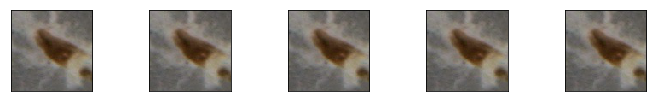

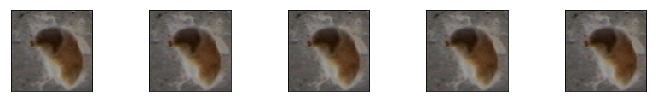

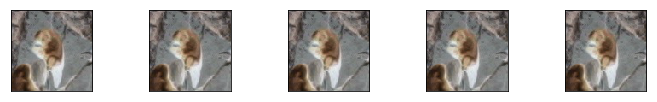

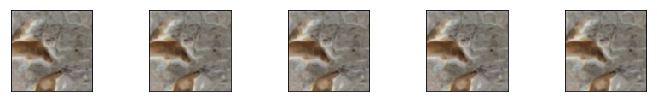

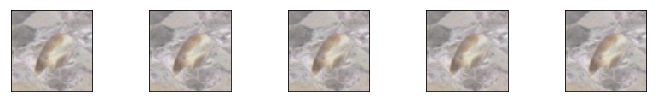

In [9]:
test_gen = ImageDataGenerator()
for x, y in test_gen.flow_from_directory(directory=TEST_PATH, target_size=(IM_HEIGHT, IM_WIDTH), classes=['sea_lions', 'background'], shuffle=False, batch_size=BATCH_SIZE):
    print(y[:5])
    for tmp in x[:5]:
        f, ax = plt.subplots(1, 5, figsize=(12, 1.5))
        axes = ax.flatten()
        j = 0
        for a in axes:
            a.set_xticks([])
            a.set_yticks([])
            for i in range(j, 5):
                j = i+1
                a.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))
                break
    break

In [6]:
# Evaluate ROC and AUC
Y_tmp = []
gen = prediction_generator_ffd()
Y_pred = parallel_model.predict_generator(gen, steps=TEST_STEPS)
Y_roc_true = np.array([[1, 0]]*SL_TEST_SIZE + [[0, 1]]*BKG_TEST_SIZE)
print(np.shape(Y_roc_true))
print(np.shape(Y_pred))
roc_auc_score(Y_roc_true, Y_pred)

Found 346015 images belonging to 2 classes.


(346015, 2)
(346015, 2)


0.6417454100256175

In [7]:
# Free memory

X_test = []
Y_test = []


In [21]:
# Save wrong predicted patches

lst = []
wrong_lst = []
tmp = os.listdir(TEST_PATH + 'sea_lions')
for elem in tmp:
    lst.append(list((TEST_PATH + 'sea_lions/' + elem, 'sea_lion')))
tmp = rand.sample(os.listdir(TEST_PATH + 'background'), SL_TEST_SIZE)
for elem in tmp:
    lst.append(list((TEST_PATH + 'background/' + elem, 'background')))
for elem in lst:
    img = cv2.imread(elem[0])
    X = np.reshape(img_to_array(img), (1, 96, 96, 3))
    X.astype('float32')
    X /= 255
    if elem[1] == 'sea_lion':
        expected_class = [1, 0]
    else:
        expected_class = [0, 1]
    prediction = parallel_model.predict(X, batch_size=1)
    if prediction[0][0] > prediction[0][1]:
        predicted_class = [1, 0]
    else:
        predicted_class = [0, 1]
    if not(expected_class == predicted_class):
        wrong_lst.append(list((elem[0], elem[1], prediction[0][0], prediction[0][1])))

wrong_prediction_df = pd.DataFrame(data=wrong_lst, columns=["image_path", "expected_class", "sl_probability", "bkg_probability"])
wrong_prediction_df.to_csv("./wrong_predictions.csv", index=False)

In [ ]:
number = 0
wrong_prediction_df = pd.read_csv("./wrong_predictions.csv")
for row in wrong_prediction_df.iterrows():
    if number == 10:
        break
    else:
        number += 1
    image = cv2.imread(row['image_path'])
    preds = [row['sl_probability'], row['bkg_probability']]
    plt.imshow(image)
    plt.axis('off')
    
    plt.figure()
    order = list(reversed(range(len(preds))))
    bar_preds = [pr[2] for pr in preds]
    labels = (pr[1] for pr in preds)
    plt.barh(order, bar_preds, alpha=0.5)
    plt.yticks(order, labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1.01)
    plt.tight_layout()
    plt.show()